## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyod.models.suod import SUOD, LOF, COPOD, IForest

## Helper Functions

In [2]:
def get_avgs(arr, fps=30):
    # average the values at some fps rate
    r = arr.size % fps
    cropped = arr[:arr.size - r].reshape(-1, fps)
    avgs = np.mean(cropped, axis=1)
    return avgs

def plot_figs(arr, xlabel, ylabel, change_ticks=False, vlines=None):
    
    cols = ['Displacement From Mean Position', 'Change in Angle per Frame']
    
    differences = np.ediff1d(arr, to_begin=0)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
    
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)
        
    for i in range(2):
        for j in range(2):
            if j == 0:
                axes[i, j].set_ylabel(f'{ylabel} (degrees)')
            else:
                axes[i, j].set_ylabel(f'Difference in {ylabel} (degrees)')
            axes[i, j].set_xlabel(f'nth {xlabel}')
            if change_ticks:
                axes[i, j].set_xticks(np.arange(arr.size))
    
    axes[0, 0].scatter(np.arange(arr.size), arr, color="b", alpha=0.5)
    axes[0, 1].scatter(np.arange(differences.size), differences, color="r", alpha=0.5)
    axes[1, 0].plot(np.arange(arr.size), arr, color="b", alpha=0.5)
    axes[1, 1].plot(np.arange(differences.size), differences, color="r", alpha=0.5)
    
    
    if vlines != None:
        for i in range(2):
            for j in range(2):
                axes[i, j].axvline(vlines[0], color ='green', lw = 2, alpha = 0.75)
                axes[i, j].axvline(vlines[1], color ='green', lw = 2, alpha = 0.75)

    fig.tight_layout()
    plt.show()
    
# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
                 LOF(n_neighbors=25), LOF(n_neighbors=35),
                 COPOD(), IForest(n_estimators=100),
                 IForest(n_estimators=200)]

def show_outliers(X_train, fps=30):
    clf = SUOD(base_estimators=detector_list, n_jobs=4, combination='average',
               verbose=False)
    clf.fit(X_train)
    outliers = np.argwhere(clf.labels_).ravel()
    scores = clf.decision_scores_
    outlier_scores = scores[outliers]
    plt.barh(outliers, outlier_scores)
    plt.title("%d FPS" % fps)
    plt.xlabel("Confidence")
    plt.ylabel("Frame Number")
    plt.show()

## Data

In [3]:
BASE_DIR = os.path.join('..', '..', 'test_videos')
arrays_dir = os.path.join(BASE_DIR, "results_arrays")

t1 = os.path.join(arrays_dir, 'Test1_tilts.npy')
p1 = os.path.join(arrays_dir, 'Test1_pans.npy')
t2 = os.path.join(arrays_dir, 'Test2_tilts.npy')
p2 = os.path.join(arrays_dir, 'Test2_pans.npy')

t1 = np.load(t1).ravel()
p1 = np.load(p1).ravel()
t2 = np.load(t2).ravel()
p2 = np.load(p2).ravel()

In [4]:
pitch = os.path.join(BASE_DIR, "asad", "pitch.txt")
roll = os.path.join(BASE_DIR, "asad", "roll.txt")
yaw = os.path.join(BASE_DIR, "asad", "yaw.txt")

pitch = np.loadtxt(pitch)
roll = np.loadtxt(roll)
yaw = np.loadtxt(yaw)

## Visualization

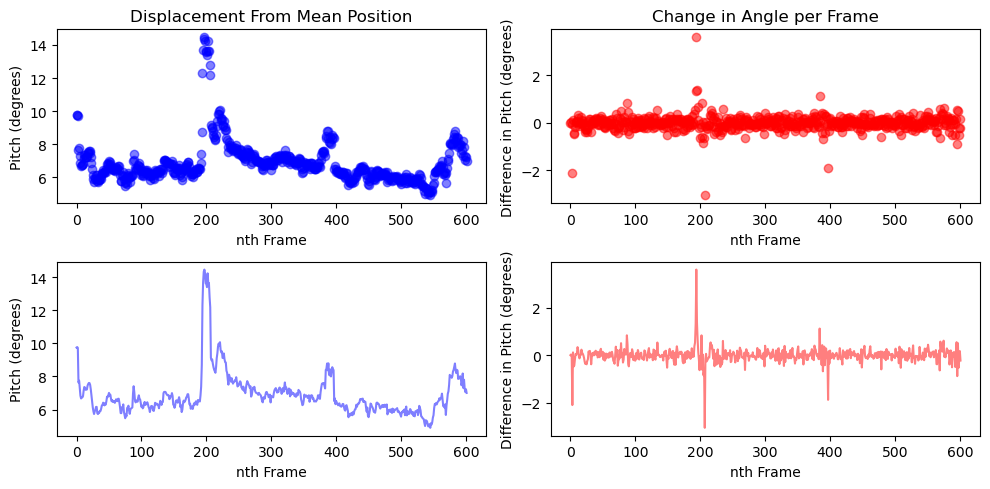

In [11]:
plot_figs(pitch, 'Frame', 'Pitch')

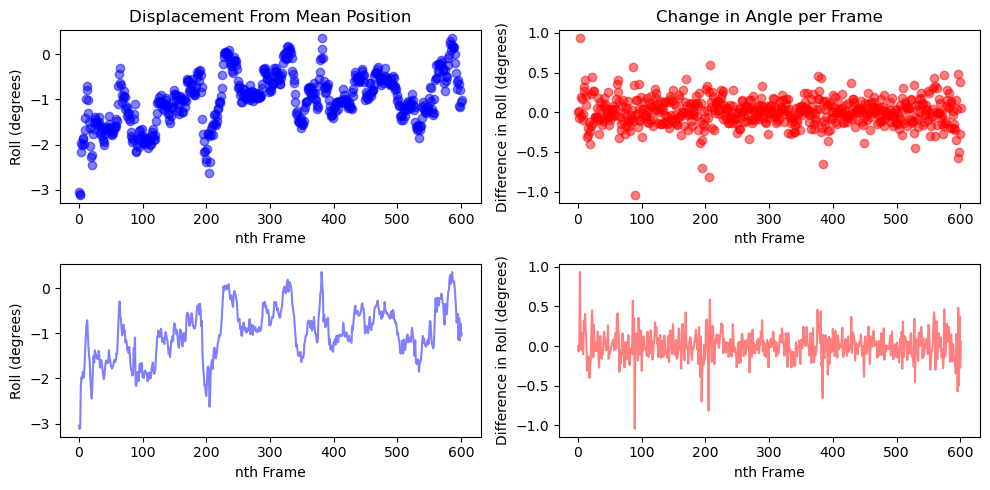

In [12]:
plot_figs(roll, 'Frame', 'Roll')

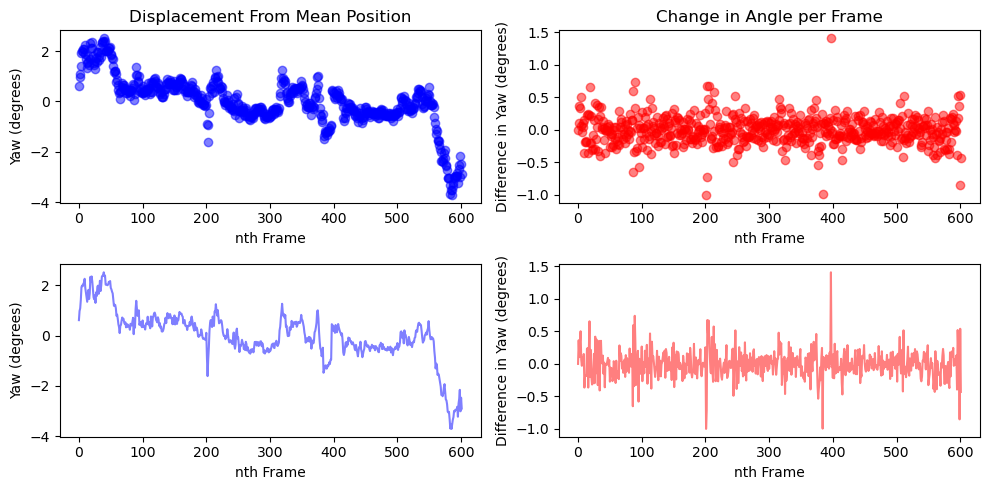

In [5]:
plot_figs(yaw, 'Frame', 'Yaw')

## Anomaly Detection

In [6]:
t1_diff = np.ediff1d(t1, to_begin=0)
p1_diff = np.ediff1d(p1, to_begin=0)
t2_diff = np.ediff1d(t2, to_begin=0)
p2_diff = np.ediff1d(p2, to_begin=0)

t1_avg30 = get_avgs(t1)
p1_avg30 = get_avgs(p1)
t2_avg30 = get_avgs(t2)
p2_avg30 = get_avgs(p2)

t1_avg30_diff = np.ediff1d(t1_avg30, to_begin=0)
p1_avg30_diff = np.ediff1d(p1_avg30, to_begin=0)
t2_avg30_diff = np.ediff1d(t2_avg30, to_begin=0)
p2_avg30_diff = np.ediff1d(p2_avg30, to_begin=0)

t1_avg15 = get_avgs(t1, 15)
p1_avg15 = get_avgs(p1, 15)
t2_avg15 = get_avgs(t2, 15)
p2_avg15 = get_avgs(p2, 15)

t1_avg15_diff = np.ediff1d(t1_avg15, to_begin=0)
p1_avg15_diff = np.ediff1d(p1_avg15, to_begin=0)
t2_avg15_diff = np.ediff1d(t2_avg15, to_begin=0)
p2_avg15_diff = np.ediff1d(p2_avg15, to_begin=0)

In [7]:
pitch_diff = np.ediff1d(pitch, to_begin=0) 
roll_diff = np.ediff1d(roll, to_begin=0) 
yaw_diff = np.ediff1d(yaw, to_begin=0) 

In [8]:
X_trains = [
    np.vstack((t1, t1_diff, p1, p1_diff)).T,
    np.vstack((t2, t2_diff, p2, p2_diff)).T,
    np.vstack((t1, t1_diff)).T,
    np.vstack((t2, t2_diff)).T,
    
    np.vstack((t1_avg30, t1_avg30_diff, p1_avg30, p1_avg30_diff)).T,
    np.vstack((t2_avg30, t2_avg30_diff, p2_avg30, p2_avg30_diff)).T,
    np.vstack((t1_avg30, t1_avg30_diff)).T,
    np.vstack((t2_avg30, t2_avg30_diff)).T,
    
    np.vstack((t1_avg15, t1_avg15_diff, p1_avg15, p1_avg15_diff)).T,
    np.vstack((t2_avg15, t2_avg15_diff, p2_avg15, p2_avg15_diff)).T,
    np.vstack((t1_avg15, t1_avg15_diff)).T,
    np.vstack((t2_avg15, t2_avg15_diff)).T,
    
    np.vstack((pitch, roll, yaw, pitch_diff, roll_diff, yaw_diff)).T
]

In [ ]:
i = 0
show_outliers(X_train[i])